# A complete study of the power from W-CalSat received in each telescope.
## _According to location and climate, elevation observation angle and telescope size._

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy import constants
import random
import warnings

warnings.filterwarnings("always", category=UserWarning)
warnings.filterwarnings("always", category=RuntimeWarning)

c = constants.speed_of_light

In [2]:
!chdir

C:\Users\Cayetano\Desktop\TFM Offline


## Power input into the W-CalSat antenna: $P_{i}$
We define the power emitted in each frequency. We try to replicate approximately the profile measured when feeding the freq synt with 10 dBm.

### Measure of the signal.

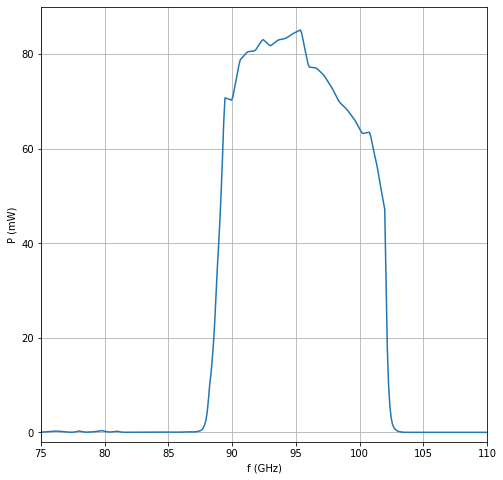

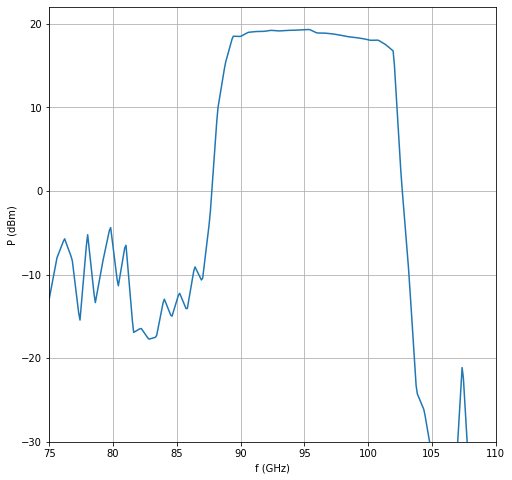

In [3]:
file = f"PS_Results_BPF.npy"
[f, Power] = np.load(file)
f = 6*f

def measured(freq):
    # Get a Power in W from the data in dBm
    
    return 10**(np.interp(freq, f, Power)/10)/1000

# Generate frequency range from 70 GHz to 120 GHz
frequency_range = np.linspace(70, 120, 500)

# Plot the measured power distribution in W
plt.figure(figsize=(8, 8)) 
plt.plot(frequency_range, 1000*measured(frequency_range))
plt.xlabel('f (GHz)')
plt.ylabel('P (mW)')
# plt.title('Potencia medida en mW enviada a la antena emisora de W-CalSat')
plt.grid(True)
plt.xlim(75,110)
plt.ylim(-2,90)
plt.savefig('measured_Pi_mW.png', dpi=400, bbox_inches='tight')
plt.show()

# Plot in dBm
plt.figure(figsize=(8, 8)) 
plt.plot(frequency_range, 10*np.log10(measured(frequency_range)*1000))
plt.xlabel('f (GHz)')
plt.ylabel('P (dBm)')
# plt.title('Potencia medida en dBm enviada a la antena emisora de W-CalSat')
plt.grid(True)
plt.xlim(75,110)
plt.ylim(-30,22)
plt.savefig('measured_Pi_dBm.png', dpi=400, bbox_inches='tight')
plt.show()

### Model for the signal.

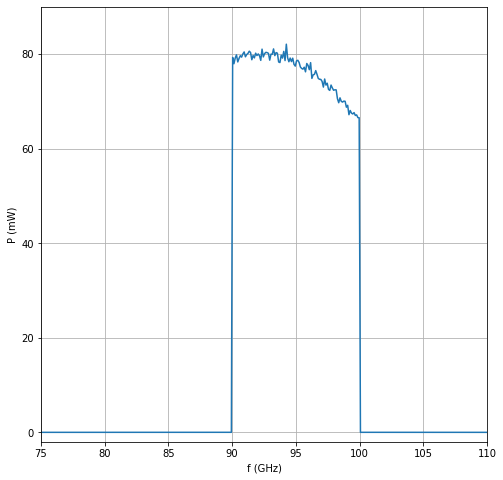

C:\Users\Cayetano\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


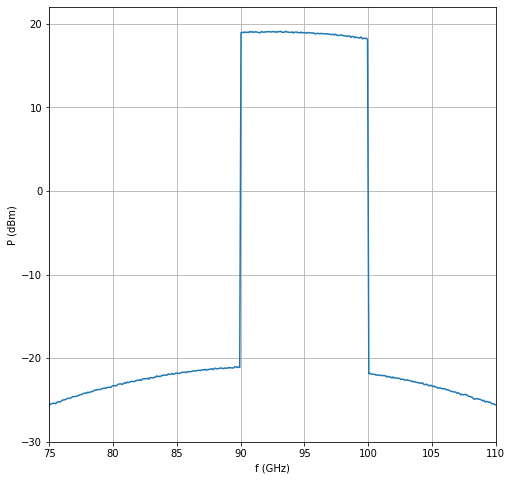

In [4]:
def modelled(freq_range):
    # Get a Power in W from the data in dBm
    
    def top_hat(x, a, b):
        return np.where((x >= a) & (x <= b), 1, 10**(-4))

    nums = []
    
    # THIS IS THE VALUE THAT CAN BE CHANGED:
    dev = 0.01
    for i in range(len(freq_range)):
        temp = 1 + random.gauss(0, dev)
        nums.append(temp)
    
    # Power at the center in mW:
    N = 80
    # Frequency center in GHz
    mu = 92.5
    sigma = 12
    
    freq_range_ghz = freq_range[np.logical_and(freq_range >= 75, freq_range <= 110)]
    power = N*np.exp(-(freq_range_ghz - mu)**2 / (2 * sigma**2))  # Gaussian function centered at 92.5 GHz with standard deviation of 5 GHz
    power_watts = power * 1e-3  # Convert power from milliwatts to watts
    power_vector = np.zeros(len(freq_range))
    power_vector[np.logical_and(freq_range >= 75, freq_range <= 110)] = power_watts
    return nums * power_vector * top_hat(freq_range,90,100)

# Generate frequency range from 70 GHz to 120 GHz
frequency_range = np.linspace(70, 120, 500)

# Plot the modelled power distribution
plt.figure(figsize=(8, 8)) 
plt.plot(frequency_range, 1000*modelled(frequency_range))
plt.xlabel('f (GHz)')
plt.ylabel('P (mW)')
# plt.title('Potencia modelada en mW enviada a la antena emisora de W-CalSat')
plt.grid(True)
plt.xlim(75,110)
plt.ylim(-2,90)
plt.savefig('modelled_Pi_W.png', dpi=500, bbox_inches='tight')
plt.show()

# Plot 2: in dBm
plt.figure(figsize=(8, 8)) 
plt.plot(frequency_range, 10*np.log10(modelled(frequency_range)*1000))
plt.xlabel('f (GHz)')
plt.ylabel('P (dBm)')
# plt.title('Potencia modelada en dBm enviada a la antena emisora de W-CalSat')
plt.grid(True)
plt.xlim(75,110)
plt.ylim(-30,22)
plt.savefig('modelled_Pi_dBm.png', dpi=400, bbox_inches='tight')
plt.show()

## Antenna gain function:
We replicate the gain for each frequencies for both avaliable antennas.

### For the horn antenna:
<img src="antenna.png" alt="drawing" width="400"/>

### For the rectangular antenna:
<img src="rect_antenna.png" alt="drawing" width="400"/>

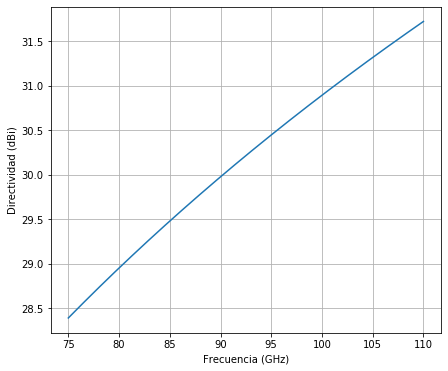

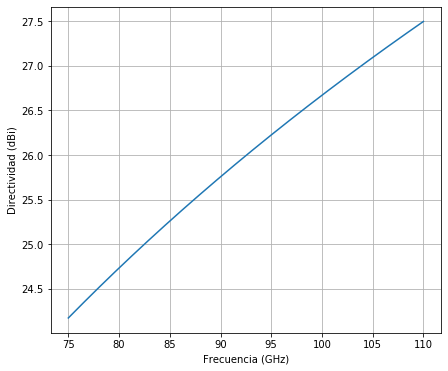

In [5]:
def horn_antenna(f):
    D = 0.053
    Gr = ((math.pi*D*f*10**9)/c)**2
    return 10*np.log10(Gr) - 4

def rect_antenna(f):
    D = 0.0326
    Gr = ((math.pi*D*f*10**9)/c)**2
    return 10*np.log10(Gr) - 4

frequency_range = np.linspace(75, 110, 500)

# Plot the gain for the lens horn antenna
plt.figure(figsize=(7, 6)) 
plt.plot(frequency_range, horn_antenna(frequency_range))
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Directividad (dBi)')
# plt.title('Directividad de la antena cónica con lente')
plt.grid(True)
plt.savefig('LHA_model.png', dpi=500, bbox_inches='tight')
plt.show()

# Plot the gain for the rectangular antenna
plt.figure(figsize=(7, 6)) 
plt.plot(frequency_range, rect_antenna(frequency_range))
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Directividad (dBi)')
# plt.title('Directividad de la antena rectangular')
plt.grid(True)
plt.savefig('RA_model.png', dpi=500, bbox_inches='tight')
plt.show()

### We define the method we are going to use.

In [6]:
# Definitive method - the only info needed of the telescope is
# the Aperture Diameter and the elevation of observation.

def Pr_defin(D, f, Latm, Lfs, dec, satHeight, Pi):
    # Pr is the total, final power that goes through the telescope
    
    # Input:
    # D = telescope aperture in m
    # f = frequency range in GHz
    # Latm = atmospheric attenuation in dB
    # Lfs = free-space path loss attenuation in dB
    # dec = declination at which the satellite is observed in degrees
    # h = height of the orbit in km
    # Pi depends on the freq; also it can be defined in several bands
    
    # Hardcoded:
    # Gr = telescope gain in magnitude: since we do not have information for...
    # every experiment in tables, we prefer this option instead.
    # Pi = power emitted by the calibration source BEFORE the emission,
    # ... Pi can be in any unit, but will be the same as the output
    # Ga = antenna gain in dBi; it is a W-band antenna!
    
    Ga = horn_antenna(f)
#     Ga = rect_antenna(f)
    h = satHeight
    
    # We get some calculations done
    d = h*1000/math.sin(math.radians(dec))
    f = f*10**9
    
    Gr = ((math.pi*D*f)/c)**2

    return  Gr * 10**( (Ga-Latm-Lfs)/10) * Pi

### Atmospheric treatment.

In [7]:
def am(satHeight,telHeight,zenith,RH,outputFile):
    import subprocess

    # Define the path to the PowerShell script
    script_path = 'atmosphere.ps1'

    # Construct the PowerShell command with variables
    command = f"powershell -File {script_path} -arg1 {satHeight} \
    -arg2 {telHeight} -arg3 {zenith} -arg4 {RH} -outputFile {outputFile}"

    # Execute the PowerShell command
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    file_encoding = 'utf-16le'  # Replace with the actual encoding of your file

    # Read in the data from the model_atacama.out file
    df = pd.read_csv(outputFile, encoding=file_encoding, sep='\s+', header=None)
    freq = df.iloc[:, 0].to_numpy()
    Latm = df.iloc[:, 1].to_numpy()
    Lfs = df.iloc[:, 2].to_numpy()
    return freq, Latm, Lfs

## Now we obtain the results:

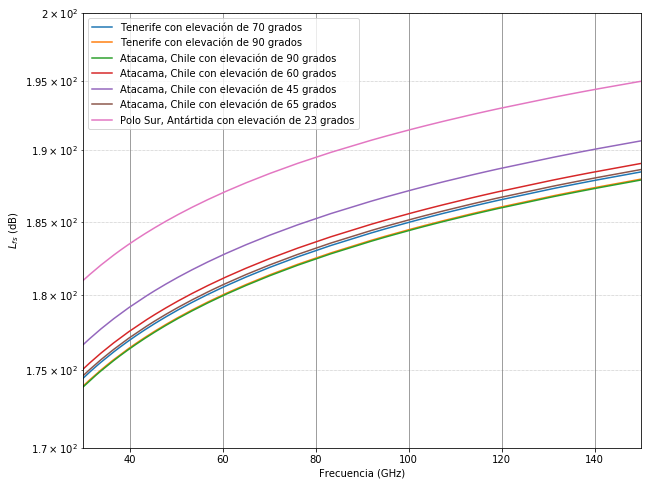

In [8]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 23}
]

# Calculate Pr_def for each telescope
Pr_def = np.array([])
fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
    # Results
    # FSPL
    loc = '%s con elevación de %d grados' % (location, elevation)
    ax.plot(freq, Lfs, label=loc)
    ax.set_yscale('log')
    ax.set_xlim(30,150)
    ax.set_ylim(170,200)
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$L_{fs}$ (dB)')
    # plt.title('$L_{fs}$ en dB frente frente a la frecuencia para distintos observatorios')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('fspl_total.png', dpi=400, bbox_inches='tight')

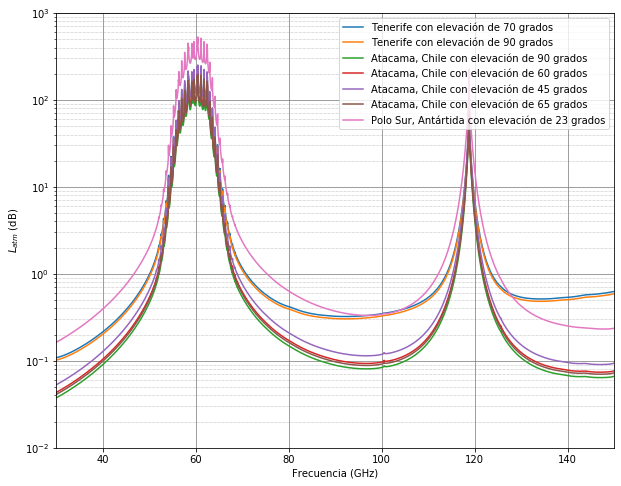

In [9]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
    # Results
    # Atmospheric absorption - total range
    loc = '%s con elevación de %d grados' % (location, elevation)
    ax.plot(freq, Latm, label=loc)
    ax.set_yscale('log')
    ax.set_xlim(30,150)
    ax.set_ylim(0.01,1000)
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$L_{atm}$ (dB)')
    # plt.title('$L_{atm}$ en dB frente frente a la frecuencia para distintos observatorios')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('atm_total.png', dpi=400, bbox_inches='tight')

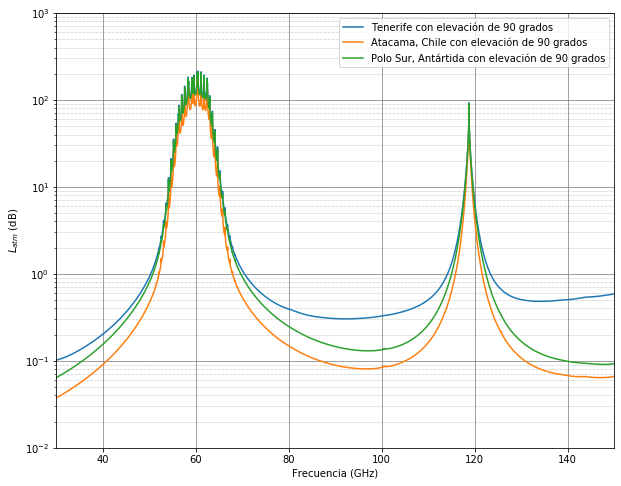

In [10]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 90}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
    # Results
    # Atmospheric absorption - total range
    loc = '%s con elevación de %d grados' % (location, elevation)
    ax.plot(freq, Latm, label=loc)
    ax.set_yscale('log')
    ax.set_xlim(30,150)
    ax.set_ylim(0.01,1000)
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$L_{atm}$ (dB)')
    # plt.title('$L_{atm}$ en dB frente frente a la frecuencia para distintos observatorios observando en el zenith')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('atm_zenith.png', dpi=400, bbox_inches='tight')

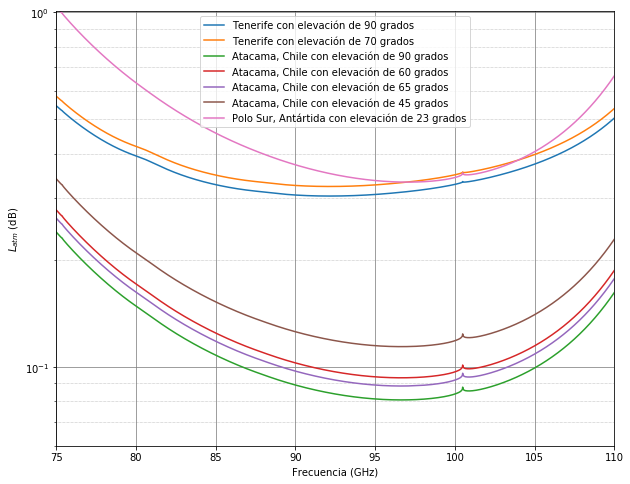

In [11]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
    # Results
    # Atmospheric absorption - W band
    loc = '%s con elevación de %d grados' % (location, elevation)
    ax.plot(freq, Latm, label=loc)
    ax.set_yscale('log')
    ax.set_xlim(75,110)
    ax.set_ylim(0.06,1.01)
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$L_{atm}$ (dB)')
    # plt.title('$L_{atm}$ en dB frente frente a la frecuencia para distintos observatorios en la badna W')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('atm_w.png', dpi=400, bbox_inches='tight')

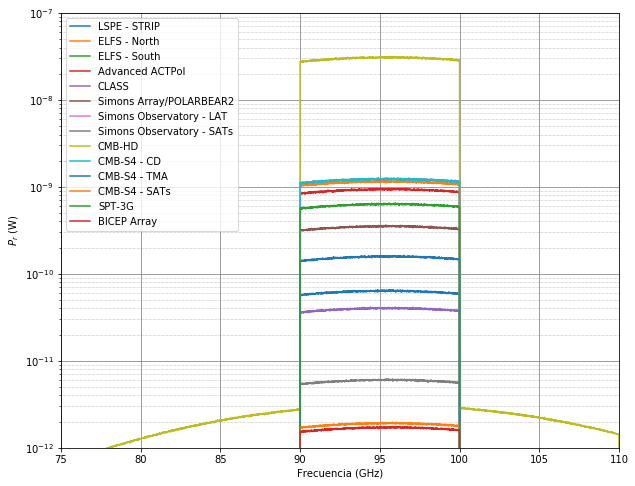

In [12]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "Simons Observatory - LAT", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Simons Observatory - SATs", "location": "Atacama, Chile", "aperture": 0.42, "elevation": 90},
    {"telescope": "CMB-HD", "location": "Atacama, Chile", "aperture": 30, "elevation": 90},
    {"telescope": "CMB-S4 - CD", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 23},
    {"telescope": "CMB-S4 - SATs", "location": "Polo Sur, Antártida", "aperture": 0.55, "elevation": 23},
    {"telescope": "SPT-3G", "location": "Polo Sur, Antártida", "aperture": 10, "elevation": 23},
    {"telescope": "BICEP Array", "location": "Polo Sur, Antártida", "aperture": 0.52, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

# Calculate Pr_def for each telescope
Pr_def = np.array([])
fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
    Pi = modelled(freq)
#     Pi = measured(freq)
    
    Pr_defin_data = Pr_defin(aperture, freq, Latm, Lfs, elevation, satHeight, Pi)
    
    Pr = Pr_defin_data[np.round(freq) == 95][0]
    Pr_def = np.append(Pr_def,{"telescope": telescope, "Power in Watts in 95 GHz": Pr})
    
    # Results
    # Final power received
    ax.plot(freq, Pr_defin_data, label=telescope)
    ax.set_yscale('log')
    ax.set_xlim(75, 110)
    ax.set_ylim(10**(-12), 10**(-7))
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$P_{r}$ (W)')
    # plt.title('$P_{r}$ en dB frente a la frecuencia para la potencia modelada')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('modelled_power.png', dpi=400, bbox_inches='tight')

In [13]:
data = Pr_def

row_names = [d['telescope'] for d in data]

# Remove the 'telescope' key from each dictionary
data = [{k: v for k, v in d.items() if k != 'telescope'} for d in data]

# Create the pandas DataFrame with row names
df = pd.DataFrame(data, index=row_names)

# Round the values
df = df.applymap(lambda x: '{:.1e}'.format(x))

# Display the DataFrame
print(df)

                          Power in Watts in 95 GHz
LSPE - STRIP                               6.4e-11
ELFS - North                               1.2e-09
ELFS - South                               1.2e-09
Advanced ACTPol                            9.2e-10
CLASS                                      4.1e-11
Simons Array/POLARBEAR2                    3.5e-10
Simons Observatory - LAT                   1.2e-09
Simons Observatory - SATs                  6.0e-12
CMB-HD                                     3.1e-08
CMB-S4 - CD                                1.2e-09
CMB-S4 - TMA                               1.6e-10
CMB-S4 - SATs                              1.9e-12
SPT-3G                                     6.2e-10
BICEP Array                                1.7e-12


### For ChatGPT: take the number column, replace the points by commas and give it to me in a copyable text window

### From the measured input power:

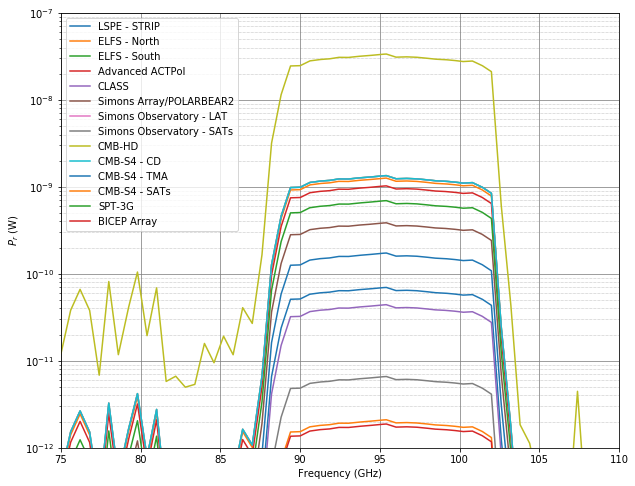

In [14]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "ELFS - North", "location": "Tenerife", "aperture": 6, "elevation": 90},
    {"telescope": "ELFS - South", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "Simons Observatory - LAT", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "Simons Observatory - SATs", "location": "Atacama, Chile", "aperture": 0.42, "elevation": 90},
    {"telescope": "CMB-HD", "location": "Atacama, Chile", "aperture": 30, "elevation": 90},
    {"telescope": "CMB-S4 - CD", "location": "Atacama, Chile", "aperture": 6, "elevation": 90},
    {"telescope": "CMB-S4 - TMA", "location": "Polo Sur, Antártida", "aperture": 5, "elevation": 23},
    {"telescope": "CMB-S4 - SATs", "location": "Polo Sur, Antártida", "aperture": 0.55, "elevation": 23},
    {"telescope": "SPT-3G", "location": "Polo Sur, Antártida", "aperture": 10, "elevation": 23},
    {"telescope": "BICEP Array", "location": "Polo Sur, Antártida", "aperture": 0.52, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

# Calculate Pr_def for each telescope
Pr_def = np.array([])
fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
#     Pi = modelled(freq)
    Pi = measured(freq)
    
    Pr_defin_data = Pr_defin(aperture, freq, Latm, Lfs, elevation, satHeight, Pi)
    
    Pr = Pr_defin_data[np.round(freq) == 95][0]
    Pr_def = np.append(Pr_def,{"telescope": telescope, "Power in Watts in 95 GHz": Pr})
    
    # Results
    # Final power received
    ax.plot(freq, Pr_defin_data, label=telescope)
    ax.set_yscale('log')
    ax.set_xlim(75, 110)
    ax.set_ylim(10**(-12), 10**(-7))
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('$P_{r}$ (W)')
    # plt.title('$P_{r}$ en dB frente a la frecuencia para la potencia medida')
    ax.set_yscale('log')
    plt.legend()
    fig.savefig('measured_power.png', dpi=400, bbox_inches='tight')

In [15]:
data = Pr_def

row_names = [d['telescope'] for d in data]

# Remove the 'telescope' key from each dictionary
data = [{k: v for k, v in d.items() if k != 'telescope'} for d in data]

# Create the pandas DataFrame with row names
df = pd.DataFrame(data, index=row_names)

# Round the values
df = df.applymap(lambda x: '{:.1e}'.format(x))

# Display the DataFrame
print(df)

                          Power in Watts in 95 GHz
LSPE - STRIP                               6.8e-11
ELFS - North                               1.2e-09
ELFS - South                               1.3e-09
Advanced ACTPol                            9.9e-10
CLASS                                      4.3e-11
Simons Array/POLARBEAR2                    3.7e-10
Simons Observatory - LAT                   1.3e-09
Simons Observatory - SATs                  6.4e-12
CMB-HD                                     3.3e-08
CMB-S4 - CD                                1.3e-09
CMB-S4 - TMA                               1.7e-10
CMB-S4 - SATs                              2.0e-12
SPT-3G                                     6.7e-10
BICEP Array                                1.8e-12


### For ChatGPT: take the number column, replace the points by commas and give it to me in a copyable text window

### From the measured input power but only existing telescopes:

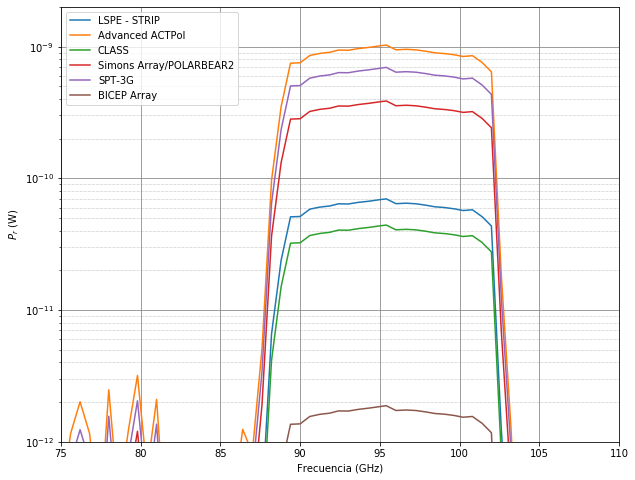

In [16]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "SPT-3G", "location": "Polo Sur, Antártida", "aperture": 10, "elevation": 23},
    {"telescope": "BICEP Array", "location": "Polo Sur, Antártida", "aperture": 0.52, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

# Calculate Pr_def for each telescope
Pr_def = np.array([])
fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
#     Pi = modelled(freq)
    Pi = measured(freq)
    
    Pr_defin_data = Pr_defin(aperture, freq, Latm, Lfs, elevation, satHeight, Pi)
    
    Pr = Pr_defin_data[np.round(freq) == 95][0]
    Pr_def = np.append(Pr_def,{"telescope": telescope, "Power in Watts in 95 GHz": Pr})
    
    # Results
    # Final power received
    ax.plot(freq, Pr_defin_data, label=telescope)
    ax.set_yscale('log')
    ax.set_xlim(75, 110)
    ax.set_ylim(10**(-12), 2*10**(-9))  
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$P_{r}$ (W)')
    # plt.title('$P_{r}$ en dB frente a la frecuencia para la potencia medida y algunos observatorios')
    ax.set_yscale('log')
    plt.legend()

In [17]:
data = Pr_def

row_names = [d['telescope'] for d in data]

# Remove the 'telescope' key from each dictionary
data = [{k: v for k, v in d.items() if k != 'telescope'} for d in data]

# Create the pandas DataFrame with row names
df = pd.DataFrame(data, index=row_names)

# Round the values
df = df.applymap(lambda x: '{:.1e}'.format(x))

# Display the DataFrame
print(df)

                        Power in Watts in 95 GHz
LSPE - STRIP                             6.8e-11
Advanced ACTPol                          9.9e-10
CLASS                                    4.3e-11
Simons Array/POLARBEAR2                  3.7e-10
SPT-3G                                   6.7e-10
BICEP Array                              1.8e-12


### For ChatGPT: take the number column, replace the points by commas and give it to me in a copyable text window

### From the measured input power but only existing telescopes:

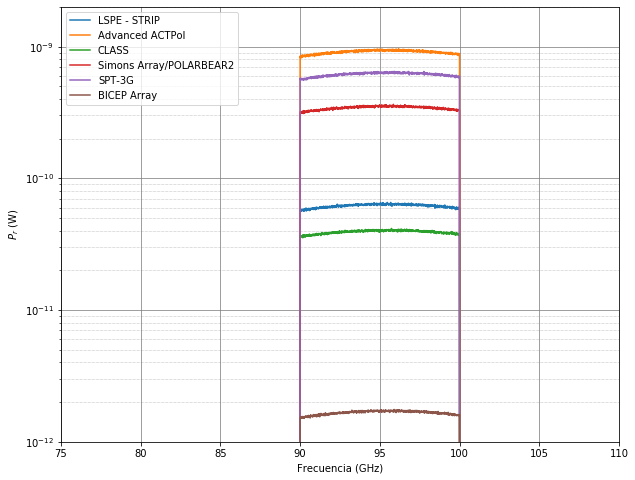

In [18]:
# Define the telescope parameters as dictionaries
telescope_params = [
    {"telescope": "LSPE - STRIP", "location": "Tenerife", "aperture": 1.5, "elevation": 70},
    {"telescope": "Advanced ACTPol", "location": "Atacama, Chile", "aperture": 6, "elevation": 60},
    {"telescope": "CLASS", "location": "Atacama, Chile", "aperture": 1.5, "elevation": 45},
    {"telescope": "Simons Array/POLARBEAR2", "location": "Atacama, Chile", "aperture": 3.5, "elevation": 65.5},
    {"telescope": "SPT-3G", "location": "Polo Sur, Antártida", "aperture": 10, "elevation": 23},
    {"telescope": "BICEP Array", "location": "Polo Sur, Antártida", "aperture": 0.52, "elevation": 23}
]

warnings.filterwarnings("ignore", message="Creating legend with loc=\"best\" can be slow with large amounts of data.")

# Calculate Pr_def for each telescope
Pr_def = np.array([])
fig, ax = plt.subplots(figsize=(10, 8))

for i, params in enumerate(telescope_params):
    aperture = params["aperture"]
    location = params["location"]
    elevation = params["elevation"]
    zenith = 90 - elevation
    telescope = params["telescope"]
    
    # Satellite height; in LEO in this case:
    satHeight = 400

    # Location info on observatory height and humidity:
    if location == "Atacama, Chile":
        telHeight = 5.2
        RH = 20
        outputFile = 'model_atacama_%d.out' % (elevation)
    if location == "Tenerife":
        telHeight = 2.4
        RH = 60
        outputFile = 'model_teide_%d.out' % (elevation)
    if location == "Polo Sur, Antártida":
        telHeight = 2.8
        RH = 5
        outputFile = 'model_sp_%d.out' % (elevation)
    
    freq = am(satHeight,telHeight,zenith,RH,outputFile)[0]
    Latm = am(satHeight,telHeight,zenith,RH,outputFile)[1]
    Lfs =  am(satHeight,telHeight,zenith,RH,outputFile)[2]
    
#     Pi = modelled(freq)
    Pi = modelled(freq)
    
    Pr_defin_data = Pr_defin(aperture, freq, Latm, Lfs, elevation, satHeight, Pi)
    
    Pr = Pr_defin_data[np.round(freq) == 95][0]
    Pr_def = np.append(Pr_def,{"telescope": telescope, "Power in Watts in 95 GHz": Pr})
    
    # Results
    # Final power received
    ax.plot(freq, Pr_defin_data, label=telescope)
    ax.set_yscale('log')
    ax.set_xlim(75, 110)
    ax.set_ylim(10**(-12), 2*10**(-9))  
    ax.grid(True)
    ax.grid(which='major', axis='both', color='grey', linestyle='-', linewidth=0.75)
    ax.grid(which='minor', axis='both', color='grey', linestyle=':', linewidth=0.5)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('$P_{r}$ (W)')
    # plt.title('$P_{r}$ en dB frente a la frecuencia para la potencia modelada y algunos observatorios')
    ax.set_yscale('log')
    plt.legend()

In [19]:
data = Pr_def

row_names = [d['telescope'] for d in data]

# Remove the 'telescope' key from each dictionary
data = [{k: v for k, v in d.items() if k != 'telescope'} for d in data]

# Create the pandas DataFrame with row names
df = pd.DataFrame(data, index=row_names)

# Round the values
df = df.applymap(lambda x: '{:.1e}'.format(x))

# Display the DataFrame
print(df)

                        Power in Watts in 95 GHz
LSPE - STRIP                             6.4e-11
Advanced ACTPol                          9.4e-10
CLASS                                    4.0e-11
Simons Array/POLARBEAR2                  3.5e-10
SPT-3G                                   6.3e-10
BICEP Array                              1.7e-12
